# Generating a Mock Sample of a Multidimensional Space

When using, please cite Buckley et al. 2024 (https://doi.org/10.1093/mnras/stae2202).

This notebook demonstrates how to generate a mock dataset in a multidimensional space using a Gaussian Mixture Model (GMM). The dataset includes:
1. Multiple Gaussian components in a defined feature space.
2. Configurable parameters such as the number of dimensions, components, and sample size.
3. Mock errors added to the dataset to simulate observational uncertainties.

Additionally, the generated data is visualised (for 2D spaces) and saved to a CSV file for further analysis.

## Importing Modules

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pandas as pd

## Define the Parameters for Mock Data Generation

This block sets the parameters for the mock dataset:
- `num_dimensions`: The number of dimensions of the feature space.
- `num_components`: The number of Gaussian components.
- `num_samples`: The total number of data points to generate.
- `min_separation`: The minimum distance between the means of the Gaussian components.
- `error_std`: The standard deviation of the mock errors to simulate uncertainties.

In [58]:
num_dimensions = 2  # Number of dimensions
num_components = 3  # Number of Gaussian components
num_samples = 10000  # Number of samples
min_separation = 2.9  # Minimum separation between component means (can be adjusted to increase or decrease the spread in groups)
error_std = 0.1  # Standard deviation of errors

## Define Function to Generate Mock Data with Errors

This function generates a mock dataset with the following steps:
1. Randomly initialises Gaussian component means with a minimum separation.
2. Generates positive-definite covariance matrices for each component.
3. Assigns weights to the components to define their contribution to the dataset.
4. Samples data points using a Gaussian Mixture Model (GMM).
5. Adds mock errors to the generated data to simulate observational uncertainties.

In [59]:
def generate_mock_data_with_errors(
    num_dimensions, num_components, num_samples, min_separation, error_std
):
    """
    Generate mock data from a Gaussian Mixture Model with full covariance matrices and add mock errors.
    Ensures minimum separation between component means.

    Parameters:
        num_dimensions (int): Number of dimensions.
        num_components (int): Number of Gaussian components.
        num_samples (int): Number of samples to generate.
        min_separation (float): Minimum distance between component means.
        error_std (float): Standard deviation of the errors.

    Returns:
        X (numpy.ndarray): The sampled data points with errors (num_samples x num_dimensions).
        y (numpy.ndarray): The labels for the components (num_samples,).
        errors (numpy.ndarray): The mock errors added to the data (num_samples x num_dimensions).
    """
    
    # Step 1: Generate means with minimum separation
    means = []
    while len(means) < num_components:
        candidate_mean = np.random.uniform(-3, 3, size=num_dimensions)  # Generate mean in the range [-3, 3]
        # Ensure minimum separation between means
        if all(np.linalg.norm(candidate_mean - existing_mean) >= min_separation for existing_mean in means):
            means.append(candidate_mean)
    means = np.array(means)

    # Step 2: Generate positive-definite covariance matrices
    covariances = []
    for _ in range(num_components):
        A = np.random.rand(num_dimensions, num_dimensions)  # Random square matrix
        full_cov = np.dot(A, A.T)  # Positive-definite covariance matrix
        covariances.append(full_cov)

    # Normalise and regularise covariances to avoid instability
    covariances = [cov / np.linalg.norm(cov) for cov in covariances]
    regularization = 1.3 # Regularisation factor
    covariances = [cov + np.eye(cov.shape[0]) * regularization for cov in covariances]

    # Step 3: Assign weights to the components
    weights = np.random.dirichlet(np.ones(num_components), size=1).flatten()

    # Step 4: Configure GaussianMixture model
    gmm = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
    gmm.means_ = means  # Assign generated means
    gmm.covariances_ = np.array(covariances) # Assign covariances
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_)) # Precision matrices
    gmm.weights_ = weights # Assign weights

    X, y = gmm.sample(num_samples) # Generate data points

    # Step 5: Add mock errors
    errors = np.random.normal(0, error_std, size=X.shape)  # Add Gaussian noise
    X += errors

    return X, y, errors


## Define Function to Plot Generated Data

This function visualizes the generated dataset for 2D spaces.

In [60]:
def plot_data(X, y):

    """
    Plot the generated data for 2D spaces.

    Parameters:
        X (numpy.ndarray): The data points.
        y (numpy.ndarray): The labels for the components.
    """
    
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y)

    # Plot each component
    for label in unique_labels:
        component_data = X[y == label]
        plt.scatter(
            component_data[:, 0], 
            component_data[:, 1], 
            label=f'Component {label}', 
            s=10
        )
    
    plt.title('Generated Data from Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Components', loc='best')
    plt.show()

## Generate and Visualize the Data

This block generates the mock dataset using the `generate_mock_data_with_errors` function and visualises it if the space is 2D using the `plot_data` function.

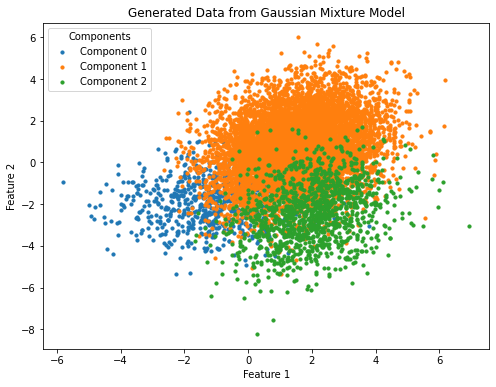

In [61]:
# Generate data with errors
X, y, errors = generate_mock_data_with_errors(num_dimensions, num_components, num_samples, min_separation, error_std)

# Visualise if 2D
if num_dimensions == 2:
    plot_data(X, y)
else:
    print(f"Data generated with {num_samples} samples in {num_dimensions} dimensions, with {num_components} components.")

## Save Data to CSV

This function saves the generated dataset, including errors and component labels, to a CSV file for further analysis.

In [62]:
def save_data_with_errors_to_csv(X, y, errors, filename="sampled_data_with_errors.csv"):

    """
    Save sampled data, errors, and their labels to a CSV file.

    Parameters:
        X (numpy.ndarray): The sampled data points (num_samples x num_dimensions).
        y (numpy.ndarray): The labels for the components (num_samples,).
        errors (numpy.ndarray): The errors for the data points (num_samples x num_dimensions).
        filename (str): The name of the CSV file to save the data to.
    """
    
    # Create column names for the data dimensions and errors
    num_dimensions = X.shape[1]
    data_columns = [f"Dimension_{i+1}" for i in range(num_dimensions)]
    error_columns = [f"Error_Dimension_{i+1}" for i in range(num_dimensions)]
    all_columns = data_columns + error_columns + ["Component_Label"]

    # Combine the data, errors, and labels into a single DataFrame
    data_with_errors_and_labels = np.hstack((X, errors, y.reshape(-1, 1)))  # Combine X, errors, and y
    df = pd.DataFrame(data_with_errors_and_labels, columns=all_columns)

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"Data with errors successfully saved to {filename}")

In [63]:
# Save to CSV
save_data_with_errors_to_csv(X, y, errors, filename="generated_data_with_errors.csv")

Data with errors successfully saved to generated_data_with_errors.csv
